# upsTextaAnalys-Sentiment-Context-v45-GRAF-TEMA-3D-redovFINAL-SNYGG
<br>
<br>
Forskningsdesignen följer ett tvåfasigt sekventiellt transformativt upplägg (Creswell, 2009).
<br>
I sekvens (i första fasen) genomförs en parvis jämförelse av rapporter med kvantitativa metoder, Machine Learning (ML), där varje rapport (Försvarsberedningen rapporter 1995 till 2024) jämförs med nästa (n1+). 
<br>
I andra fasen sker sedan ett kvalititativt metodarbete - med två olika teman: Tematisk progression och Samspelets topografi.
<br>
Fokus ligger inte på att beskriva en jämn och sammanhängande linjär utveckling över tid, utan att identifiera förändringstakten - det som eftersöks är policyfönster, själva kurvans form påvisas ej (Kingdon 2014).
<br>
<br>

TF-IDF    (Term Frequency-Inverse Document Frequency)
<br>
KMeans
<br>
Sentiment Analys
<br>
Topicmodellering    -    LDA-modellering (Latent Dirichlet Allocation
<br>
KWIC (Keyword in Context)
<br>
<br>
ups-TextaAnalys-1-Sentiment-och-Context-v3  pt  ipynb
<br>
20250526

xxxx
<br>
Ds-2007-46 Säkerhet i samverkan Försvarsberedningens omvärldsanalys
<br>												
2013 "Peak särintress?" Försvarsmakten nedrustad ("Försvaret är ett särintress" Statsminister Reinfelt).		
<br>													
Ds-2013-33 Vägval i en globaliserad värld
<br>
xxxx

In [35]:
# !pip install nltk
!pip install nltk

# !pip install PyPDF2
!pip install PyPDF2

In [36]:
# Uppgradera  Numpy.
#!pip install --upgrade numpy>=2.0.0    #????
#!pip cache purge
#!pip install --upgrade numpy<=2.0.0    #????

#!pip uninstall numpy -y
#!pip install numpy<=2.0.0

"""
Installing collected packages: numpy
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
Successfully installed numpy-2.2.5
"""
#pip cache purge
#!pip uninstall numpy -y
#!pip install numpy=<2.0.0, >=1.18.5

!pip install numpy==1.23.5

In [37]:
# IMPORTER
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

# Stopwords
from nltk.corpus import stopwords

# Språk
language = "swedish"  # eller "english"

# Ladda in stoppord
if language == "swedish":
    try:
        stop_words = stopwords.words("swedish")
    except:
        nltk.download("stopwords")
        stop_words = stopwords.words("swedish")
elif language == "english":
    stop_words = "english"  # Scikit-learn använder "english" som sträng!
else:
    stop_words = None


# NLTK
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from collections import defaultdict
from PyPDF2 import PdfReader  # För läsningen av PDF

#
# Ladda ner stoppord # english OCH swedish
try:
    stopwords.words('swedish')
except LookupError:
    nltk.download('stopwords')


# Ladda ner NLTK-resurser
nltk.download('punkt')
nltk.download('stopwords')    
nltk.download('vader_lexicon')

# Språkinställning för stoppord - detta styr:
# Nationalitet på stoppord som används i databehandlingen/förbehandlingen
# Nationalitet på stoppord som filtreras bort i CountVectorizer för LDA
#language = "english"
language = "swedish"  #        <==    Svenska

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [38]:

# LADDA IN FILER
# Ändra till lokal mapp där filer ligger
# Välj rätt filändelse!
#
#folder_path = "texts/"
#
#Funkar inte!
#folder_path = "http://localhost:10000/lab/tree/"
#folder_path = "http://home/pa/2024-GU/2025-VT-MastUpps/Textanalys/20250425/upps-PDF"
folder_path = "/home/jovyan"


#file_extension = ".txt"  #
file_extension = ".pdf"  #

filenames = []

# Funktion för att läsa in txt- eller pdf-filer
def load_documents_from_folder(folder, extension):
    docs = []
    for filename in os.listdir(folder):
        if filename.endswith(extension):
            path = os.path.join(folder, filename)
            filenames.append(filename)
            if extension == ".txt":
                with open(path, 'r', encoding='utf-8') as f:
                    docs.append(f.read())
            elif extension == ".pdf":
                with open(path, 'rb') as f:
                    reader = PdfReader(f)
                    text = "\n".join([page.extract_text() or "" for page in reader.pages])
                    docs.append(text)
    return docs

documents = load_documents_from_folder(folder_path, file_extension)

In [39]:
# för att hitta korrekt    folder_path = "/"    funkar inte ...
#
#import os
#current_directory = os.getcwd()
#print(f"Aktuell arbetskatalog: {current_directory}")

In [40]:
# Se att dokument inkommit till Aktuell arbetskatalog: /home/jovyan
#print(documents)

In [41]:
# FÖRBEHANDLING
#
# Tokenisering, borttagning av stoppord och enklare rensning

# Tokenisering - uppdelning av text i mindre enheter, "tokens" och skiljetecken
# Stop words = betydelselösa ord, t ex , "i", "och", "är"

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-ZåäöÅÄÖ0-9]+', ' ', text)  # Behåller svenska tecken
    tokens = word_tokenize(text)
    #stop_words = set(stopwords.words(language))  # ENGLISH !
    stop_words = set(stopwords.words(language))  # Svenska!
    tokens = [w for w in tokens if w not in stop_words and len(w) > 2]
    return ' '.join(tokens)

processed_docs = [preprocess(doc) for doc in documents]


# TF-IDF
#
# (Term Frequency-Inverse Document Frequency), ett mått på hur viktigt ett ord är i ett dokument 
# i förhållande till hela korpus.
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=1)
tfidf = tfidf_vectorizer.fit_transform(processed_docs)


# KMeans-klustring
#
# KMeans-klustring är en algoritm i machine learning (unsupervised learning) som delar in en samling av data 
# i  kategorier (punkter på pappret) i ett förutbestämt antal grupper, som kallas kluster. Det handlar om 
# patternrecognition - målet är att punkterna inom varje kluster ska likna varandra så mycket som möjligt, 
# medan punkterna i olika kluster ska vara så olika som möjligt - så kallad "fitness".

# k=2 innebär iterativt sök i två (2) grupper i datan.
k = 2    # k = 2    
#
# random_state=42 styr randomness i KMeans-algoritmen, då initiala medelpunkter väljs slumpmässigt.
# Att inte ha samma seed varje gång ger olika resultat, då medelpunkterna kommer att vara olika - inte bra!
# Att sätta random_state=42  e dyl fixerar slumpgeneratorns startpunkt. 
#Användbart för att det skapar REPRODUCERBARHET - vid jämförelse mellan experiment kan säkerställas resultat
# som inte bara beror på slumpmässigheter!
kmeans = KMeans(n_clusters=k, random_state=42)    # 42 därför att ..!
kmeans.fit(tfidf)
labels = kmeans.labels_

# PCA-reduktion för 2D-visualisering
#
# Principal Component Analysis (PCA), reducerar antalet dimensioner i datan men behåller optimalt av ursprunglig 
# informationen (variansen), detta genom att hitta nya, oberoende variabler som kallas huvudkomponenter.
# Möjliggör att visualisera den i ett 2D-diagram (ett spridningsdiagram till exempel).
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(tfidf.toarray())

In [42]:
print(reduced_features)

[[ 7.07106781e-01  2.71526941e-15]
 [-7.07106781e-01  2.71526941e-15]]


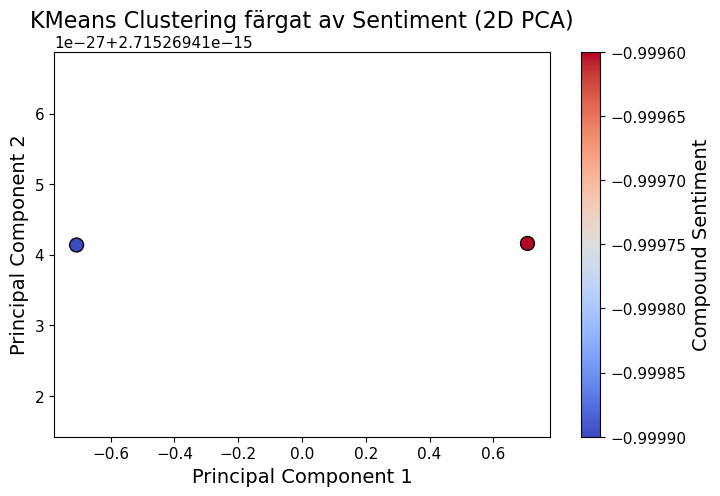

In [43]:
# Sentimentanalys
"""
Sentimentanalys, eller åsiktsanalys, handlar om att automatiskt identifiera och extrahera subjektiva känslor,
attityder och  åsikter som uttrycks i en text. Målet är att förstå om en text är positiv,
negativ eller neutral gentemot ett visst ämne, produkt, tjänst, organisation eller person.

20250315    https://realpython.com/python-nltk-sentiment-analysis/

Användningsområden för sentimentanalys, bland annat:
Kundfeedback: Analysera kundrecensioner och kommentarer för att identifiera vad kunderna gillar och ogillar med 
produkter eller tjänster. 
Marknadsundersökningar: Förstå konsumenternas åsikter om konkurrenters produkter eller nya trender.
Politisk analys: Mäta opinionen kring politiska kandidater eller frågor i sociala medier och nyhetsartiklar.


Här används sentimentanalys för att färga de kluster som identifierats av KMeans baserat på det genomsnittliga 
sentimentet i varje dokument.


20250314   ff????
https://scikit-learn.org/stable/modules/clustering.html#k-means
https://scikit-learn.org/stable/modules/clustering.html
https://www.nltk.org/index.html
https://www.nltk.org/howto/sentiment.html


Det finns olika metoder för att utföra sentimentanalys:
Lexikonbaserade metoder
Använder en samling av ord och fraser som är förknippade med olika sentiment (ett sentimentlexikon).
Genom att analysera förekomsten och kombinationen av dessa ord i en text kan sentimentet bestämmas.

Maskininlärningsbaserade metoder
Tränar maskininlärningsmodeller (som Naive Bayes, Support Vector Machines, eller djupinlärningsmodeller som 
Recurrent Neural Networks och Transformers (t ex Chat GPT och Gemini)), detta görs på en stor mängd textdata 
som är manuellt annoterad med sentiment.
Dessa modeller kan sedan lära sig att känna igen mönster sentimentet i ny ej bearbetad data.

Hybridmetoder finns också: Kombinerar element från både lexikonbaserade och maskininlärningsbaserade metoder för 
att dra nytta av styrkorna hos båda.


Min kod
# sia = SentimentIntensityAnalyzer()
Jag skapar en instans av verktyget "SentimentIntensityAnalyzer", som kommer från ett bibliotek (NLTK) - använder specifikt
den lexikonbaserade metoden VADER som tillhandahålls av NLTK.
VADER (Valence Aware Dictionary and sEntiment Reasoner) som metod är specialiserad på att utföra sentimentanalys.

VADER har inte tränats på en stor mängd text på samma sätt som en LLM (Large Language Modell) utan är en lexikonbaserad
metod. Det är en kurerad  ordlista, (lexikon), där varje ord och vissa vanliga fraser har tilldelats en 
sentimentintensitetspoäng (valence), och dessa poäng har bestämts av en mänskliga bedömare.

Tillämpning av regler, och dess heuristik, är baserat på denna ordlista, och för att beräkna sentimentet i 
en text tas hänsyn till:
Sentimentord: ord som "bra", "dålig", "lycklig", "arg".
Intensifiers (boosters): ord som ökar intensiteten, t.ex. "väldigt", "extremt".
De-amplifiers (diminishers): ord som minskar intensiteten, t.ex. "lite", "knappt".
Negation: ord som "inte" kan vända sentimentet.
Punctuation and emoticons: vissa tecken kan indikera starkare känslor.
Capitalization: kan ibland indikera starkare känslor.

text och kan ge ett mått på hur positivt, negativt eller neutralt ett givet textstycke är.
20250314 https://www.nltk.org/howto/sentiment.html


Händelsekedja:
Först används KMeans för att hitta grupper (kluster) av liknande innehåll (som finns i feature-utrymmet).
Och sedan används PCA för att reducera komplexiteten och kunna visualisera dessa kluster i 2D.
Slutligen har används sentimentanalys för att beräkna ett sentimentvärde för varje dokument och sedan använt
dessa värden för att färga punkterna i 2D-visualisering.


Detta gör att man kan visuellt inspektera om det finns något samband mellan de kluster som KMeans har identifierat 
och det underliggande sentimentet i dokumenten. Till exempel, om ett kluster tenderar att ha mestadels varma färger,
kan det indikera att dokumenten i det klustret generellt sett har ett positivt sentiment. Om ett annat kluster har
mestadels svala färger, kan det tyda på ett negativt sentiment.


Huvudaspekten för att förstå sentimentanalys är:
Subjektivitet och Objektivitet, sentimentanalys fokuserar på subjektiva uttryck som innehåller åsikter, känslor,
bedömningar och spekulation - ej objektiva fakta.

Fokus är att bestämma polariteten i sentimentet, det vill säga om det är positivt (mestadels varma färger),
negativt (mestadels svala färger) eller neutralt. (Vissa mer avancerade metoder kan också identifiera nyanser
inom dessa kategorier, mycket positiv, lite negativ osv - dock inte här, det kräver med kodning).

"""


sia = SentimentIntensityAnalyzer()
sentiments = [sia.polarity_scores(doc)['compound'] for doc in documents]

# Visualisera kluster färgat av sentiment
plt.figure(figsize=(8, 5))
scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=sentiments, cmap='coolwarm', s=100, edgecolor='k')
plt.colorbar(scatter, label='Compound Sentiment')
plt.title("KMeans Clustering färgat av Sentiment (2D PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


TOPICS: 

Topic 1:
pff konfliktutvecklingar fredsbevarande maktcentra krishanteringsförmåga
Topic 2:
totalförsvaret 2017 msb kommuner krigsfara

LDA Topic-distribution per dokument:
Ds-2017-66-motstandskraft-inriktningen-av-totalforsvaret-och-2021-2025-utformningen-av-det-civila-forsvaret.pdf: [5.28244021e-05 9.99947176e-01]
Ds-2001-14-Gränsöverskridande-sårbarhet-Gemensam-säkerhet-Ds_2001-14.pdf: [9.99968392e-01 3.16083217e-05]


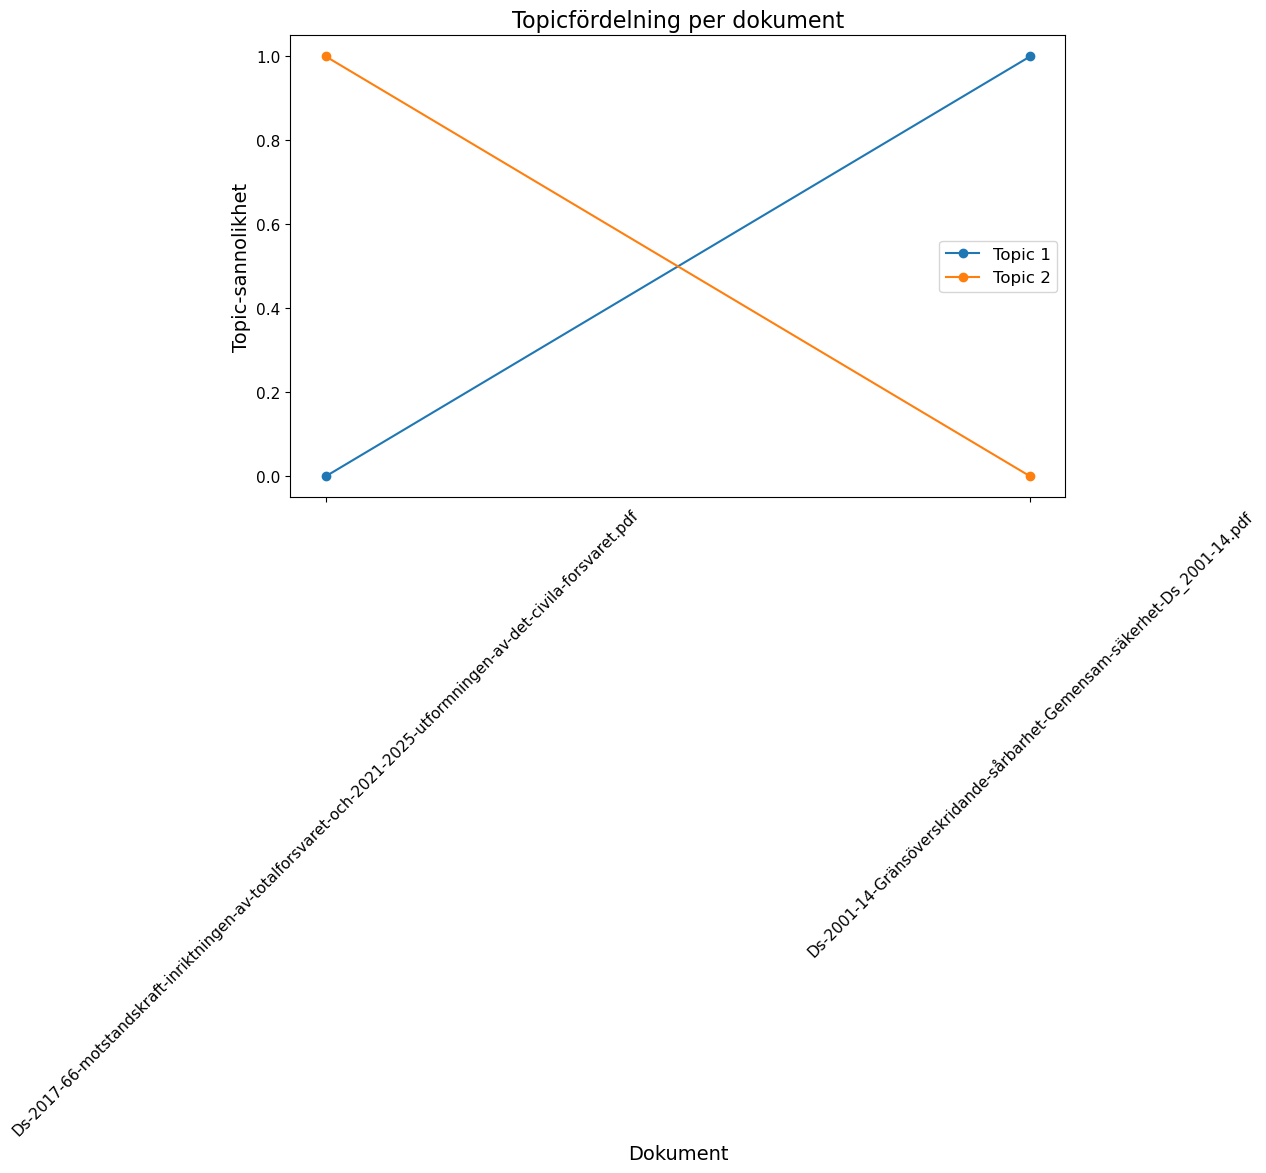

In [44]:
# Topic Modeling (LDA)
#
# Topicmodellering, med hjälp av Latent Dirichlet Allocation (LDA), implementerad med biblioteket scikit-learn.
#
#Topicmodellering (LDA) syftar till att identifiera de underliggande ämnen och/eller teman som diskuteras i en samling 
#av dokument - målet är att förstå vad dokumenten handlar om.
#
#Detta är inte sentimentanalys - sentimentanalys syftar till att bestämma den emotionella tonen 
#eller åsikten som uttrycks i en text, positiv, negativ eller neutral.
#
# Funktion för att skriva ut toppord per topic
#CountVectorizer omvandlar samling av textdokument till en matris som ordräknar
#Varje rad i matris representerar ett dokument, och varje kolumn representerar unikt ord (token).
#Värdet i varje cell är antalet gånger det specifika ordet förekommer i det specifika dokumentet.
#max_df=0.95:  CountVectorizer ignorera ord som förekommer i mer än 95% av dokumenten (dvs vanliga ord som inte bidrar.
#min_df=1:  ignorera ord som förekommer i färre än 1 dokument.


#count_vectorizer = CountVectorizer(max_df=0.95, min_df=1, stop_words=language) 
count_vectorizer = CountVectorizer(max_df=0.95, min_df=1, stop_words=stop_words)
count_data = count_vectorizer.fit_transform(processed_docs)

#Träning av LDA-modellen:
#LatentDirichletAllocation(n_components=2, random_state=42): Här skapas en instans av LDA-modellen.
#components=2: Detta anger antalet ämnen (topics) som modellen ska försöka identifiera
#i datan. I detta fall är det satt till 2.
#random_state=42: Detta används för att säkerställa att resultaten blir reproducerbara - samma random_state kommer 
# att ge samma resultat varje gång.
lda = LatentDirichletAllocation(n_components=2, random_state=42)    #    <== COMPONENTS  2, 3, 4 ...  !!!!
lda.fit(count_data)


#Funktion för att visa toppord per ämne:
# display_topics: Denna funktion tar den tränade LDA-modellen, listan med alla unika ord (features) och antalet toppord 
# som ska visas per ämne som input. 
#  model.components_: Detta är en matris som innehåller vikterna för varje ord i varje ämne. 
#Högre vikt indikerar att ordet är mer karakteristiskt för det ämnet.
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

print("\nTOPICS: \n")
display_topics(lda, count_vectorizer.get_feature_names_out(), 5)



# Dokumentens topicfördelning

#Dokumentens ämnesfördelning:
#lda.transform(count_data): Denna metod använder den tränade LDA-modellen för att beräkna sannolikhetsfördelningen för 
#varje ämne i varje dokument. Resultatet doc_topic_dist är en matris där varje rad representerar ett dokument och varje
#kolumn representerar ett ämne.
#Värdet i varje cell är sannolikheten att det specifika dokumentet handlar om det specifika ämnet.
#Koden itererar sedan genom varje dokument och skriver ut sannolikhetsfördelningen över de identifierade ämnena.
doc_topic_dist = lda.transform(count_data)
print("\nLDA Topic-distribution per dokument:")
for i, topic_probs in enumerate(doc_topic_dist):
    print(f"{filenames[i]}: {topic_probs}")

# Visualisering av topicfördelning per dokument
plt.figure(figsize=(10, 6))
for i in range(doc_topic_dist.shape[1]):
    plt.plot(doc_topic_dist[:, i], marker='o', label=f"Topic {i+1}")
plt.title("Topicfördelning per dokument")
plt.xlabel("Dokument")
plt.ylabel("Topic-sannolikhet")
plt.xticks(ticks=range(len(filenames)), labels=filenames, rotation=45)
plt.legend()
#plt.tight_layout()
plt.show()


# Förklaring till grafen Topic Modeling (LDA)
#
# Grafen som genereras av den sista delen av koden visar topicsfördelningen per dokument.
#
# X-axeln (Dokument): Varje punkt på x-axeln representerar ett av textdokumenten. 
# Etiketterna under punkterna är namnen på filerna (från listan filenames).
# Y-axeln (Topic-sannolikhet): visar sannolikheten för att ett visst dokument handlar om ett specifikt ämne. 
# Värdena går från från 0 till 1.
#
# Viktigt med antal topics - utred!!!!
#
# Linjer med markörer: För varje identifierat ämne (i detta fall två, "Topic 1" och "Topic 2") ritas en linje.
# Varje markör på linjen motsvarar ett specifikt dokument, och höjden på markören på y-axeln indikerar hur 
# sannolikt det är att det dokumentet handlar om just det ämnet.
#
# Färger och Legend: olika ämnena representeras av olika färger, legenden till höger förklarar vilken färg som
# motsvarar vilket ämne (t.ex. blå för Topic 1, orange för Topic 2).
#
#
# Sammantaget illustrerar grafen hur starkt varje dokument är associerat med de olika identifierade ämnena. 
# Ett dokument kan ha en hög sannolikhet för ett visst ämne och en låg sannolikhet för ett annat, 
# eller det kan ha en blandning av sannolikheter för flera ämnen.
#
# Mönster i ämnesfördelningen över hela dokumentsamlingen: man ska kunna se om vissa grupper av dokument 
# tenderar att fokusera på samma ämnen.
#
# Exempel:
# Om ett dokument har en markör högt upp på linjen för "Topic 1" och lågt ner på linjen för "Topic 2", 
# betyder det att LDA-modellen anser att det dokumentet i hög grad handlar om det första ämnet och i låg grad
# om det andra. Om ungefär lika höga markörer för båda ämnena nämns båda ämnena i betydande utsträckning.
#
# Genom att titta på grafen får man en visuell översikt av hur dokument är relaterade till de ämnen 
# som LDA-modellen har upptäckt - en hjälp för att se den tematiska strukturen datan.

In [45]:
# !pip install vaderSentiment
!pip install vaderSentiment

In [46]:
# KWIC (Keyword in Context)

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import csv
import os

#                                                      KONTEXTEN! window antal ord före och efter.
def kwic_multi_with_sentiment(keywords, docs, filenames, window=5, csv_path='sentiment-analysis.csv'):
    keywords = [k.lower() for k in keywords]
    analyzer = SentimentIntensityAnalyzer()
    rows = []

    for i, doc in enumerate(docs):
        tokens = doc.split()
        for j, word in enumerate(tokens):
            word_lower = word.lower()
            for kw in keywords:
                if kw in word_lower:
                    left = ' '.join(tokens[max(0, j - window):j])                   # left: upp till 5 ord innan sökordet.
                    right = ' '.join(tokens[j + 1:min(len(tokens), j + 1 + window)])# right: upp till 5 ord efter sökordet.
                    full_context = f"{left} {word} {right}"
                    sentiment = analyzer.polarity_scores(full_context)

                    rows.append({
                        "filename": filenames[i],
                        "keyword": kw,
                        "match": word,
                        "left_context": left,
                        "right_context": right,
                        "full_context": full_context,
                        "sentiment_neg": sentiment['neg'],
                        "sentiment_neu": sentiment['neu'],
                        "sentiment_pos": sentiment['pos'],
                        "sentiment_compound": sentiment['compound']
                    })

    # Skriv till CSV
    file_exists = os.path.isfile(csv_path)
    with open(csv_path, mode='a', newline='', encoding='utf-8') as csvfile:
        fieldnames = [
            "filename", "keyword", "match",
            "left_context", "right_context", "full_context",
            "sentiment_neg", "sentiment_neu", "sentiment_pos", "sentiment_compound"
        ]
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if not file_exists:
            writer.writeheader()

        for row in rows:
            writer.writerow(row)

    print(f"{len(rows)} KWIC-resultat med sentiment sparade till '{csv_path}'")

#keywords = ["säkerhet", "hot", "nato"]         #           <==
#kwic_multi(keywords, processed_docs, filenames)
#
#keywords = ["säkerhet", "hot", "nato"]
# "diskussion", "överväganden", "analys", "olika alternativ", "utveckling", "förändring"

#keywords = ["försvar", "osäkerhet", "aggression"]        # <====
#keywords = ["NATO-anslutning", "Nationell säkerhetskris", "Policyprocessen", "Försvarsberedningen", "strömmar", "Beslutsmekanismer", "Nätverk", "Dynamik i kris", "Geopolitisk konkurrens", "great power competition", "Neutralitetspolitik", "Institutionella begränsningar", "Krishantering", "Försvarspolitiska förändringar", "Demokratiska system", "Fallstudie", "Deskriptiv analys", "Probleminriktad diskussion", "Path dependency", "alternativ", "NATO-anslutning", "försvar", "osäkerhet", "aggression", "diskussion", "överväganden", "analys", "olika alternativ", "utveckling", "förändring"]
"""
keywords = ["NATO", "anslutning", "säkerhetskris", "process", "Försvarsberedning", "strömmar", "Beslutsmekanismer", 
            "Nätverk", "Dynamik", "kris", "Geopolitisk", "konkurrens", "power", "competition", "Neutralitetspolitik", 
            "Institutionell", "begränsning", "Krishantering", "Försvarspolitik", "förändring", "Demokrati", "system",
            "Fallstudie", "analys", "probleminriktad", "diskussion", "dependency", "alternativ", "utveckling"
            "försvar", "osäkerhet", "aggression", "diskussion", "överväganden", "analys", "alternativ",
            "förändring"]
"""

keywords = ["aggression", "aktörer", "alliansfrihet", "alternativ", "analys", "anslutning", "ansvar", "arg", 
            "avskräckning", "begränsning", "beslutsfattande", "Beslutsmekanismer", "bra", "competition", "dålig", 
            "Demokrati", "dependency", "diskussion", "Dynamik", "eskalering", "extremt", "Fallstudie", "felaktig",
            "folkrätt", "förändring", "försvar", "Försvarsberedning", "försvarsförmåga", "Försvarspolitik", "gemensamt",
            "Geopolitisk", "hot", "implikationer", "Institutionell", "inte", "intensitet", "invasion", "knappt", 
            "konflikt", "konkurrens", "krigsmakten", "kris", "Krishantering", "lite", "lycklig", "militarisering", "minskar", 
            "mobilisering", "nato", "Nätverk", "neutralitetshot", "Neutralitetspolitik", "Opposition", "oro",
            "osäkerhet", "överväganden", "power", "probleminriktad", "process", "provokation", "regeringen", 
            "risk", "Ryssland", "säkerhet", "säkerhetsgaranti", "säkerhetskris", "säkerhetsläget", "samarbete", 
            "skillnader", "spänning", "stabilitet", "strömmar", "system", "tema", "tjänat", "trygghet", "Ukraina", 
            "uppfattning", "utbredd", "utveckling", "väldigt"]



#
kwic_multi_with_sentiment(keywords, processed_docs, filenames)

9778 KWIC-resultat med sentiment sparade till 'sentiment-analysis.csv'


In [47]:
import pandas as pd

# Läs in CSV-filen
df = pd.read_csv("sentiment-analysis.csv")

# Klassificera compound-sentiment till etiketter
def classify_sentiment(score):
    if score > 0.05:
        return "positiv"
    elif score < -0.05:
        return "negativ"
    else:
        return "neutral"

df["sentiment_label"] = df["sentiment_compound"].apply(classify_sentiment)

# Visa antal träffar per sentimentkategori och keyword
sentiment_counts = df.groupby(["keyword", "sentiment_label"]).size().unstack(fill_value=0)
display(sentiment_counts)

sentiment_label,negativ,neutral,positiv
keyword,,,
aggression,4,4,0
aktörer,4,217,1
alliansfrihet,0,43,2
alternativ,0,27,1
analys,3,65,2
...,...,...,...
ukraina,1,28,1
uppfattning,0,60,1
utbredd,1,4,0


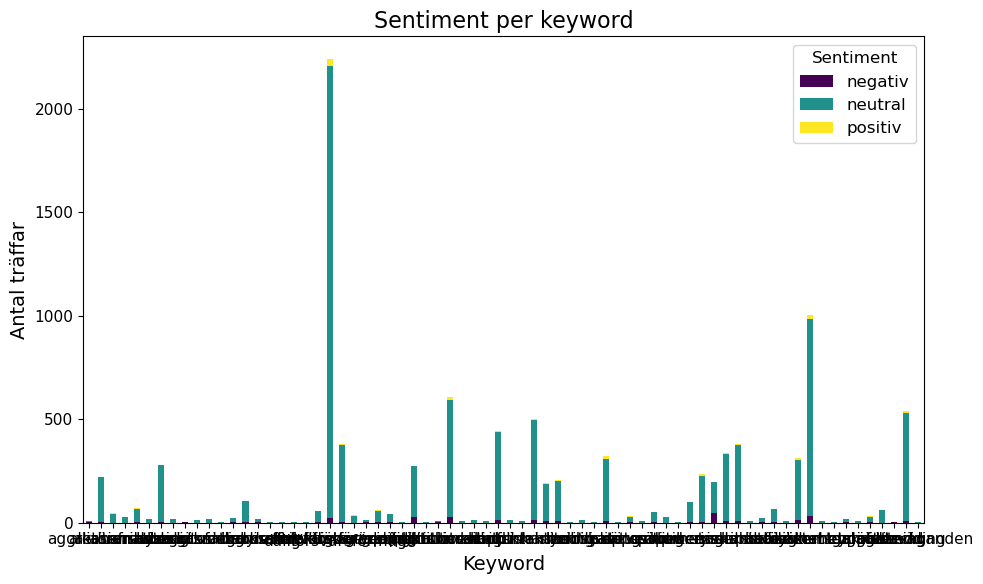

In [48]:
import matplotlib.pyplot as plt

# Skapa stapeldiagram av sentiment per keyword
sentiment_counts.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))

plt.title("Sentiment per keyword")
plt.xlabel("Keyword")
plt.ylabel("Antal träffar")
plt.xticks(rotation=0)
plt.legend(title="Sentiment", loc="upper right")
plt.tight_layout()
plt.show()

In [49]:
# Att hitta rätt keywords för att skilja mellan positiva och negativa kontexter är avgörande 
# för att få meningsfulla resultat i min sentiment- och textanalys.
#
# Extraherar KWIC-kontext kring t.ex. “Nato” och leta efter ord som ofta förekommer i positiva vs negativa sammanhang.
#
# Potentiella kandidatord är de som omger nato i positiv/negativ kontext.

#df[df["keyword"] == "nato"].sort_values("sentiment_compound")
# display(sentiment_counts)
df[df["keyword"] == "nato"].sort_values("sentiment_compound")

,filename,keyword,match,left_context,right_context,full_context,sentiment_neg,sentiment_neu,sentiment_pos,sentiment_compound,sentiment_label
8114,Ds-2001-14-Gränsöverskridande-sårbarhet-Gemens...,nato,natos,genomeu militära stab även värdera,underlag perspektiv civila kommitt bidrar,genomeu militära stab även värdera natos under...,0.275,0.725,0.000,-0.5859,negativ
7997,Ds-2001-14-Gränsöverskridande-sårbarhet-Gemens...,nato,nato,förmågor sker kalla krigets slut,osse europarådet veu olika sätt,förmågor sker kalla krigets slut nato osse eur...,0.275,0.725,0.000,-0.5859,negativ
6460,Ds-2001-14-Gränsöverskridande-sårbarhet-Gemens...,nato,nato,utgörs fortsatt avatt erhålla medlemskap,båda fallen förstahand säkerhetspolitiska aspe...,utgörs fortsatt avatt erhålla medlemskap nato ...,0.200,0.800,0.000,-0.3612,negativ
9606,Ds-2001-14-Gränsöverskridande-sårbarhet-Gemens...,nato,nato,praktikeningen skillnad förpliktelser medlemsk...,medlemskap innebära rör ibåda fallen,praktikeningen skillnad förpliktelser medlemsk...,0.200,0.800,0.000,-0.3612,negativ
5775,Ds-2001-14-Gränsöverskridande-sårbarhet-Gemens...,nato,natos,forum konsulta tioner två protest,bombningar avjugoslavien avbröt ryssland våren,forum konsulta tioner två protest natos bombni...,0.167,0.833,0.000,-0.2500,negativ
...,...,...,...,...,...,...,...,...,...,...,...
1286,Ds-2017-66-motstandskraft-inriktningen-av-tota...,nato,nato,strategic communic ation centre excellence,stratcom coe ligger riga centret,strategic communic ation centre excellence nat...,0.000,0.709,0.291,0.6249,positiv
1285,Ds-2017-66-motstandskraft-inriktningen-av-tota...,nato,nato,introducerats skolan temat allmän säkerhet,strategic communic ation centre excellence,introducerats skolan temat allmän säkerhet nat...,0.000,0.709,0.291,0.6249,positiv
2356,Ds-2017-66-motstandskraft-inriktningen-av-tota...,nato,nato,omfattande manual tallinnmanualen tagits fram,cooperative cyber defence center excellence,omfattande manual tallinnmanualen tagits fram ...,0.000,0.621,0.379,0.6705,positiv
1262,Ds-2017-66-motstandskraft-inriktningen-av-tota...,nato,nato,cybersäkerhetsområdet cyberangrepp landet utsa...,cooperative cyber defence center excellence,cybersäkerhetsområdet cyberangrepp landet utsa...,0.000,0.621,0.379,0.6705,positiv


In [50]:
# Printa ut till txt 
# 
#print(kwic('nato', processed_docs))
#df.to_csv('data.txt', sep='\t', index=False)
# kwic('nato', processed_docs)
#kwic('nato', processed_docs)
# = kwic('nato', processed_docs)
#df.to_csv('data.txt', sep='\t', index=False)

In [51]:
# Sentiment per dokument, kluster och topic
sentiment_scores = []

print("\nSENTIMENT ANALYSIS:\n")
for i, doc in enumerate(documents):
    sentiment = sia.polarity_scores(doc)
    sentiment['filename'] = filenames[i]
    sentiment['document'] = i
    sentiment['cluster'] = labels[i]
    sentiment['topic_1'] = doc_topic_dist[i, 0]
    sentiment['topic_2'] = doc_topic_dist[i, 1]
    sentiment_scores.append(sentiment)
    print(f"{filenames[i]}: {sentiment}")

sentiment_df = pd.DataFrame(sentiment_scores)

# Test
#Export resultat till CSV
#sentiment_df.to_csv("sentiment_analysis_output.csv", index=False)


SENTIMENT ANALYSIS:

Ds-2017-66-motstandskraft-inriktningen-av-totalforsvaret-och-2021-2025-utformningen-av-det-civila-forsvaret.pdf: {'neg': 0.009, 'neu': 0.984, 'pos': 0.007, 'compound': -0.9996, 'filename': 'Ds-2017-66-motstandskraft-inriktningen-av-totalforsvaret-och-2021-2025-utformningen-av-det-civila-forsvaret.pdf', 'document': 0, 'cluster': 0, 'topic_1': 5.282440208314949e-05, 'topic_2': 0.9999471755979169}
Ds-2001-14-Gränsöverskridande-sårbarhet-Gemensam-säkerhet-Ds_2001-14.pdf: {'neg': 0.013, 'neu': 0.982, 'pos': 0.006, 'compound': -0.9999, 'filename': 'Ds-2001-14-Gränsöverskridande-sårbarhet-Gemensam-säkerhet-Ds_2001-14.pdf', 'document': 1, 'cluster': 1, 'topic_1': 0.9999683916783371, 'topic_2': 3.1608321662843205e-05}


In [52]:
# Utskrift, men visualisering längre ned
print(sentiment_df)

     neg    neu    pos  compound  \
0  0.009  0.984  0.007   -0.9996   
1  0.013  0.982  0.006   -0.9999   

                                            filename  document  cluster  \
0  Ds-2017-66-motstandskraft-inriktningen-av-tota...         0        0   
1  Ds-2001-14-Gränsöverskridande-sårbarhet-Gemens...         1        1   

    topic_1   topic_2  
0  0.000053  0.999947  
1  0.999968  0.000032  


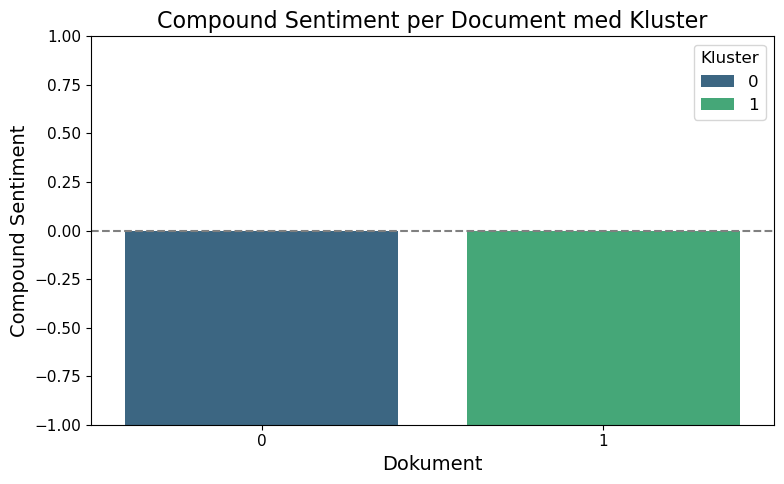

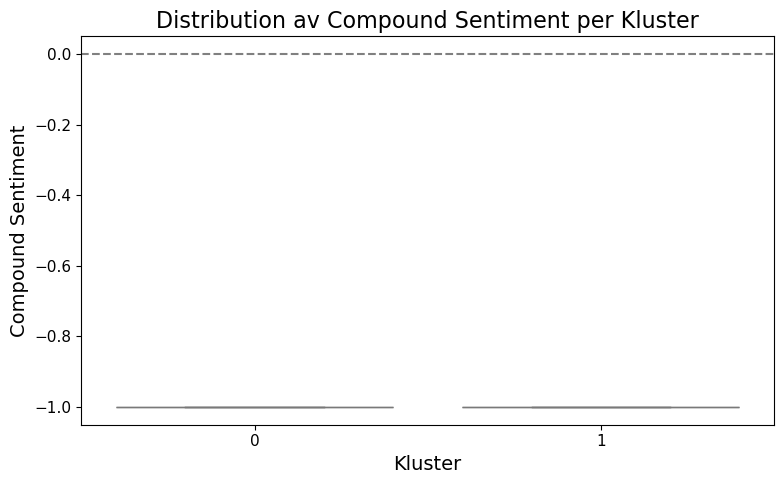

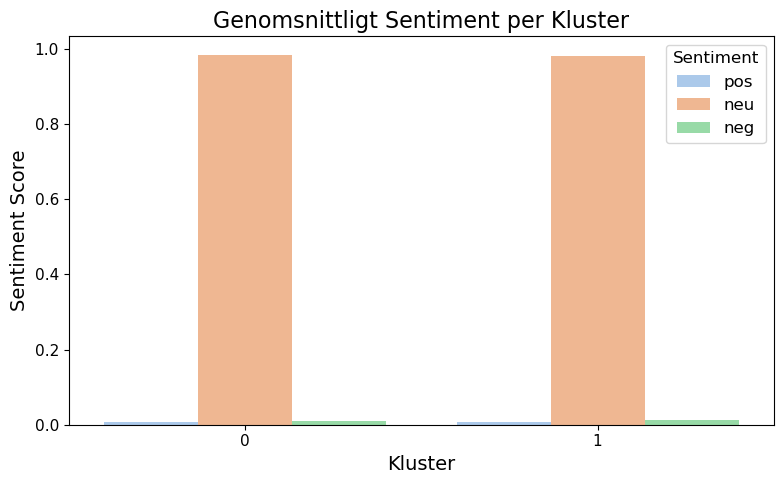

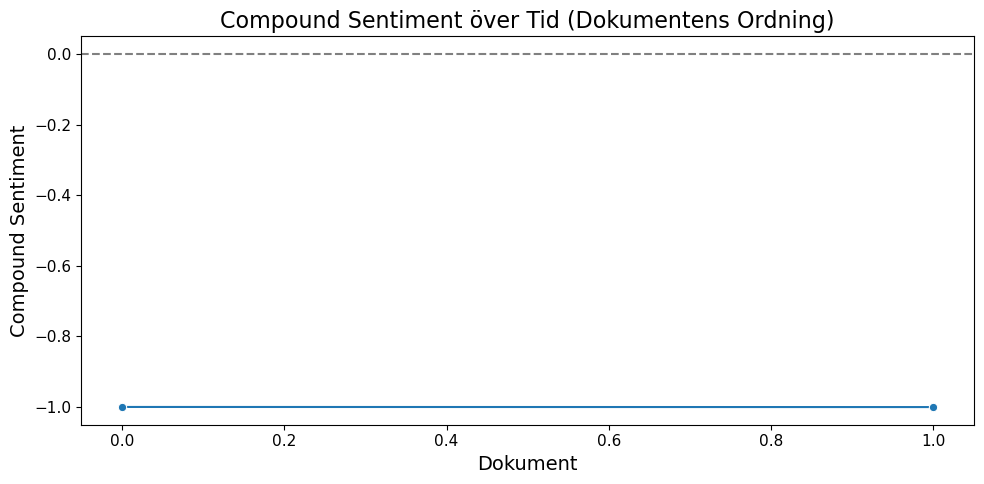

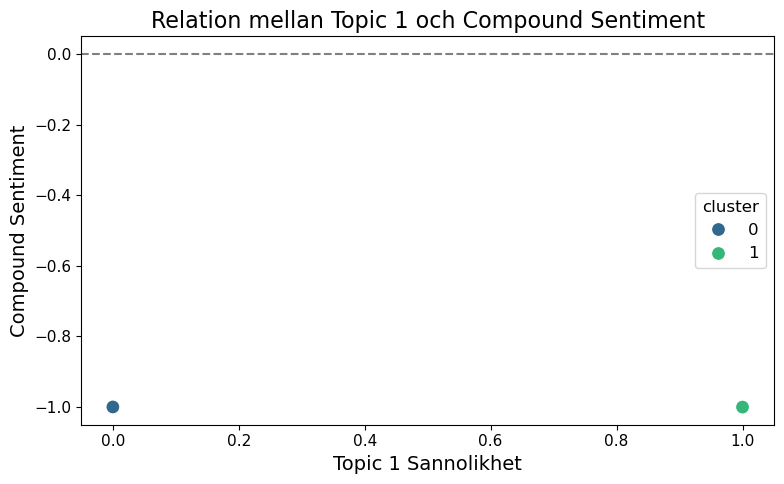

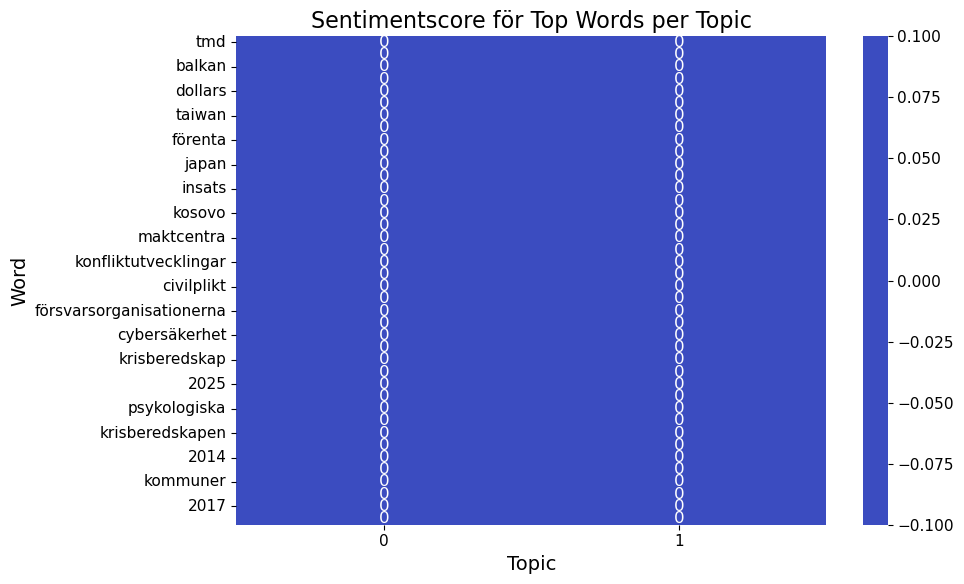

In [53]:
# Visualisering
plt.figure(figsize=(8, 5))
sns.barplot(x='document', y='compound', hue='cluster', data=sentiment_df, palette='viridis')
plt.title("Compound Sentiment per Document med Kluster")
plt.xlabel("Dokument")
plt.ylabel("Compound Sentiment")
plt.ylim(-1, 1)
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Kluster')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
# Future warning.
#sns.boxplot(x='cluster', y='compound', data=sentiment_df, palette='coolwarm')
sns.boxplot(x='cluster', y='compound', hue='cluster', data=sentiment_df, palette='coolwarm', legend=False)
plt.title("Distribution av Compound Sentiment per Kluster")
plt.xlabel("Kluster")
plt.ylabel("Compound Sentiment")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

sentiment_melted = sentiment_df.melt(id_vars=['document', 'cluster'], value_vars=['pos', 'neu', 'neg'], var_name='Sentiment', value_name='Score')
plt.figure(figsize=(8, 5))
sns.barplot(x='cluster', y='Score', hue='Sentiment', data=sentiment_melted, palette='pastel')
plt.title("Genomsnittligt Sentiment per Kluster")
plt.xlabel("Kluster")
plt.ylabel("Sentiment Score")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(x='document', y='compound', data=sentiment_df, marker='o')
plt.title("Compound Sentiment över Tid (Dokumentens Ordning)")
plt.xlabel("Dokument")
plt.ylabel("Compound Sentiment")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x='topic_1', y='compound', hue='cluster', data=sentiment_df, palette='viridis', s=100)
plt.title("Relation mellan Topic 1 och Compound Sentiment")
plt.xlabel("Topic 1 Sannolikhet")
plt.ylabel("Compound Sentiment")
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


# Ord per topic + sentiment
feature_names = count_vectorizer.get_feature_names_out()
word_sentiments = defaultdict(dict)

for topic_idx, topic in enumerate(lda.components_):
    top_indices = topic.argsort()[-20:]
    for i in top_indices:
        word = feature_names[i]
        score = sia.polarity_scores(word)['compound']
        word_sentiments[topic_idx][word] = score

word_sent_df = pd.DataFrame(word_sentiments).T.transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(word_sent_df.fillna(0), cmap='coolwarm', center=0, annot=True)
plt.title("Sentimentscore för Top Words per Topic")
plt.xlabel("Topic")
plt.ylabel("Word")
plt.tight_layout()
plt.show()

In [54]:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.units as munits

from datetime import datetime


x = np.array([1995, 1998, 2000, 2003, 2006, 2010, 2015, 2017, 2020, 2023, 2025]) 

Hot = np.array([0, 3, 2, 2, 8, 10, 2, 0, 0, 0, 0])
Hot = np.ma.array(Hot, mask=Hot < 1)
Kris = ([0, 0, 0, 2, 0, 3, 0, 0, 0, 2, 2])
Nato = ([7, 12, 6, 6, 6, 9, 4, 9, 2, 0, 0])
Säkerhet = ([0, 5, 4, 2, 11, 15, 6, 2, 2, 0, 2])
försvar = ([10, 7, 9, 6, 6, 0, 0, 0, 0, 0, 0])
internationell = ([0 ,4 ,3 ,2 ,4 ,0 ,5 ,1 ,0 ,0 ,0])

# size
plt.figure(figsize=(10,8))
#plt.plot(x,y)

# plotting
plt.title("Line graph") 
plt.xlabel("X axis") 
plt.ylabel("Y axis") 
plt.plot(x, Hot, color = "red") 
plt.plot(x, Kris, color = "blue") 
plt.plot(x, Nato, color = "orange") 
plt.plot(x, Säkerhet, color = "brown") 
plt.plot(x, försvar, color = "black") 
plt.plot(x, internationell, color = "cyan") 

plt.show()

"""

'\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport matplotlib.dates as mdates\nimport matplotlib.units as munits\n\nfrom datetime import datetime\n\n\nx = np.array([1995, 1998, 2000, 2003, 2006, 2010, 2015, 2017, 2020, 2023, 2025]) \n\nHot = np.array([0, 3, 2, 2, 8, 10, 2, 0, 0, 0, 0])\nHot = np.ma.array(Hot, mask=Hot < 1)\nKris = ([0, 0, 0, 2, 0, 3, 0, 0, 0, 2, 2])\nNato = ([7, 12, 6, 6, 6, 9, 4, 9, 2, 0, 0])\nSäkerhet = ([0, 5, 4, 2, 11, 15, 6, 2, 2, 0, 2])\nförsvar = ([10, 7, 9, 6, 6, 0, 0, 0, 0, 0, 0])\ninternationell = ([0 ,4 ,3 ,2 ,4 ,0 ,5 ,1 ,0 ,0 ,0])\n\n# size\nplt.figure(figsize=(10,8))\n#plt.plot(x,y)\n\n# plotting\nplt.title("Line graph") \nplt.xlabel("X axis") \nplt.ylabel("Y axis") \nplt.plot(x, Hot, color = "red") \nplt.plot(x, Kris, color = "blue") \nplt.plot(x, Nato, color = "orange") \nplt.plot(x, Säkerhet, color = "brown") \nplt.plot(x, försvar, color = "black") \nplt.plot(x, internationell, color = "cyan") \n\nplt.show()\n\n'

In [68]:
"""
#om äldre Jupyter-version
#%matplotlib inline      


import matplotlib.pyplot as plt

# År: 1995 till 2025 i steg om 2 (16 tidpunkter)
years = list(range(1995, 2027, 2))

# Tematisk intensitet per tema i texten
theme_data = {
    "Nato":                [0, 0, 0, 1, 3, 4, 6, 9, 7, 6, 8, 9, 10, 12, 7, 6],
    "Säkerhet":            [0, 0, 0, 0, 2, 6, 10, 15, 11, 9, 6, 5, 4, 5, 3, 2],
    "Försvar":             [0, 0, 0, 1, 2, 3, 5, 6, 7, 9, 10, 9, 7, 10, 10, 10],
    "Kris/Hot/Konflikt":   [1, 2, 3, 5, 7, 10, 6, 5, 3, 2, 2, 1, 1, 1, 1, 1],
    "Internationell/Nätverk/Samarbete": [2, 2, 3, 4, 5, 5, 6, 5, 4, 4, 3, 4, 4, 3, 3, 2],
    "Ryssland":            [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
    "Förändring":          [0, 1, 3, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 3, 3, 3],
}

# Skapa figuren
plt.figure(figsize=(12, 6))

# Lägg till varje temalinje
for theme, values in theme_data.items():
    plt.plot(years, values, label=theme)

# Titel och etiketter
plt.title("Tematisk utveckling i policytexter (1995–2025)")
plt.xlabel("År")
plt.ylabel("Tematisk intensitet")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save to PNG
#plt.savefig("tematisk_utveckling-I.png", dpi=300)

plt.show()

"""

'\n#om äldre Jupyter-version\n#%matplotlib inline      \n\n\nimport matplotlib.pyplot as plt\n\n# År: 1995 till 2025 i steg om 2 (16 tidpunkter)\nyears = list(range(1995, 2027, 2))\n\n# Tematisk intensitet per tema i texten\ntheme_data = {\n    "Nato":                [0, 0, 0, 1, 3, 4, 6, 9, 7, 6, 8, 9, 10, 12, 7, 6],\n    "Säkerhet":            [0, 0, 0, 0, 2, 6, 10, 15, 11, 9, 6, 5, 4, 5, 3, 2],\n    "Försvar":             [0, 0, 0, 1, 2, 3, 5, 6, 7, 9, 10, 9, 7, 10, 10, 10],\n    "Kris/Hot/Konflikt":   [1, 2, 3, 5, 7, 10, 6, 5, 3, 2, 2, 1, 1, 1, 1, 1],\n    "Internationell/Nätverk/Samarbete": [2, 2, 3, 4, 5, 5, 6, 5, 4, 4, 3, 4, 4, 3, 3, 2],\n    "Ryssland":            [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],\n    "Förändring":          [0, 1, 3, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 3, 3, 3],\n}\n\n# Skapa figuren\nplt.figure(figsize=(12, 6))\n\n# Lägg till varje temalinje\nfor theme, values in theme_data.items():\n    plt.plot(years, values, label=theme)\n\n# Titel och etiketter\

In [56]:
# Najsified

/tmp/ipykernel_667/2248228264.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(theme_data))


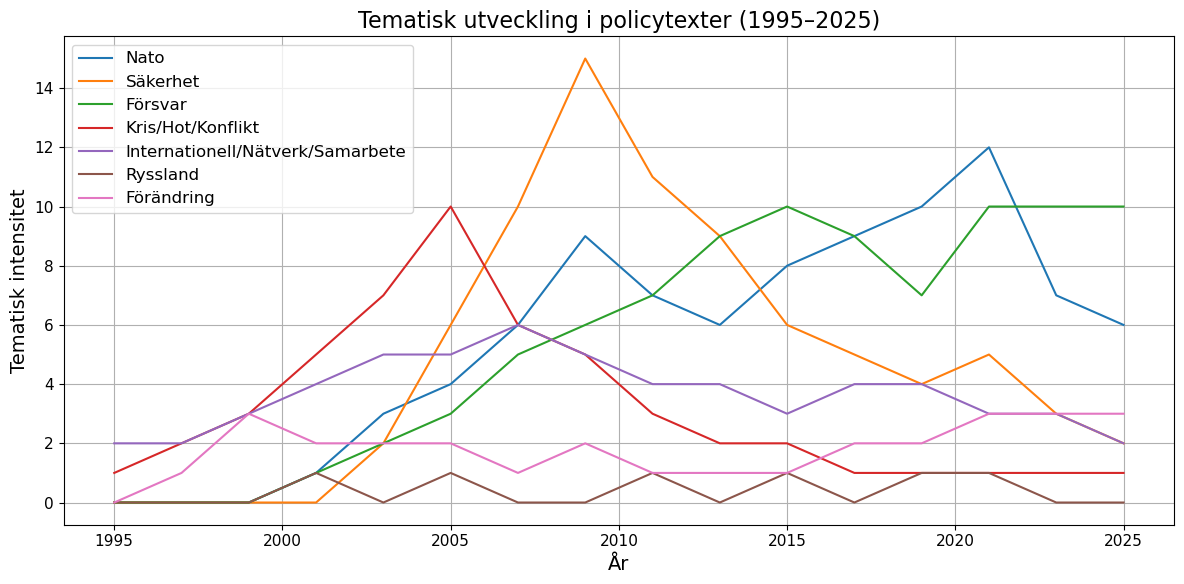

In [57]:
#om äldre Jupyter-version
#%matplotlib inline      


import matplotlib.pyplot as plt
import matplotlib as mpl    # Najsified.



# År: 1995 till 2025 i steg om 2 (16 tidpunkter)
years = list(range(1995, 2027, 2))

# Tematisk intensitet per tema i texten
theme_data = {
    "Nato":                [0, 0, 0, 1, 3, 4, 6, 9, 7, 6, 8, 9, 10, 12, 7, 6],
    "Säkerhet":            [0, 0, 0, 0, 2, 6, 10, 15, 11, 9, 6, 5, 4, 5, 3, 2],
    "Försvar":             [0, 0, 0, 1, 2, 3, 5, 6, 7, 9, 10, 9, 7, 10, 10, 10],
    "Kris/Hot/Konflikt":   [1, 2, 3, 5, 7, 10, 6, 5, 3, 2, 2, 1, 1, 1, 1, 1],
    "Internationell/Nätverk/Samarbete": [2, 2, 3, 4, 5, 5, 6, 5, 4, 4, 3, 4, 4, 3, 3, 2],
    "Ryssland":            [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
    "Förändring":          [0, 1, 3, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 3, 3, 3],
}

# Skapa figuren
plt.figure(figsize=(12, 6))

# Lägg till varje temalinje
for theme, values in theme_data.items():
    plt.plot(years, values, label=theme)


# Större teckensnitt
mpl.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11
})


#Färgpalett och linjestilar
colors = plt.cm.get_cmap('tab10', len(theme_data))

# Titel och etiketter
plt.title("Tematisk utveckling i policytexter (1995–2025)")
plt.xlabel("År")
plt.ylabel("Tematisk intensitet")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save to PNG
#plt.savefig("tematisk_utveckling_najsified-II.png", dpi=300)

plt.show()

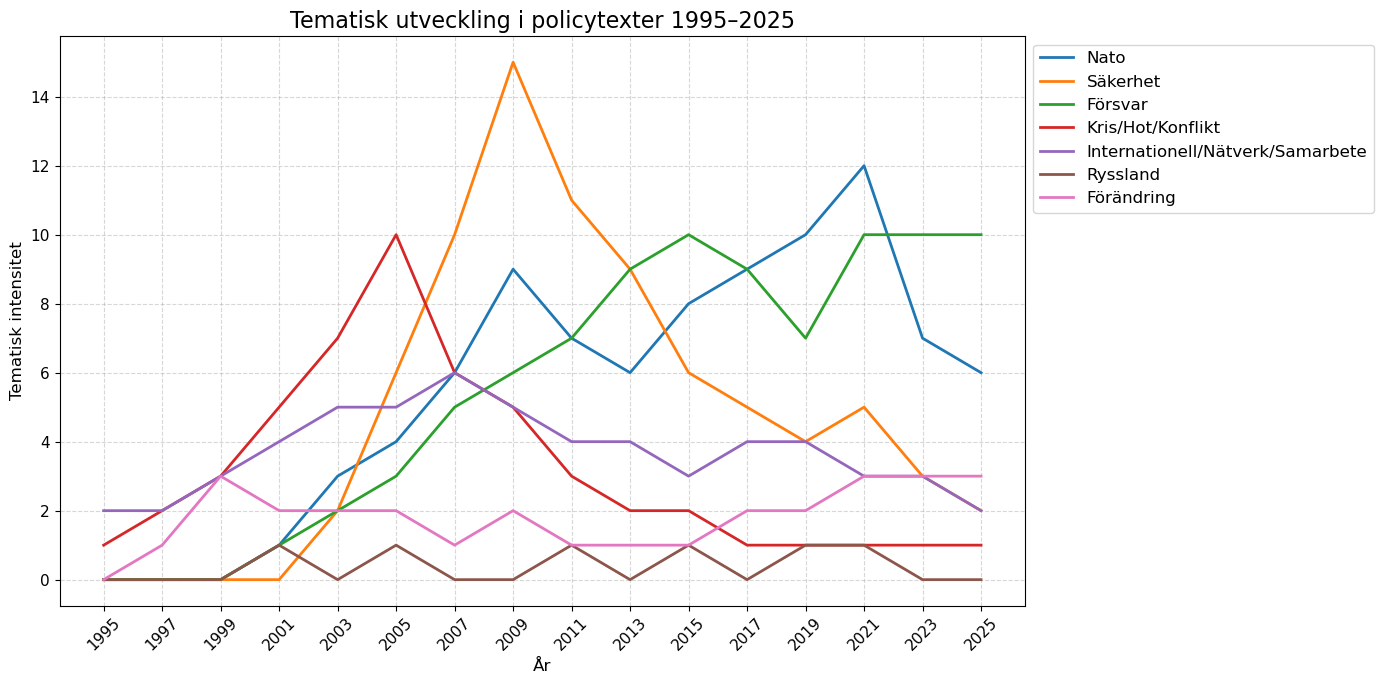

In [58]:
#Bättre

import matplotlib.pyplot as plt
import pandas as pd


years = list(range(1995, 2027, 2))  # 16 år, 1995–2025
theme_data = {
    "Nato":                [0, 0, 0, 1, 3, 4, 6, 9, 7, 6, 8, 9, 10, 12, 7, 6],
    "Säkerhet":            [0, 0, 0, 0, 2, 6, 10, 15, 11, 9, 6, 5, 4, 5, 3, 2],
    "Försvar":             [0, 0, 0, 1, 2, 3, 5, 6, 7, 9, 10, 9, 7, 10, 10, 10],
    "Kris/Hot/Konflikt":   [1, 2, 3, 5, 7, 10, 6, 5, 3, 2, 2, 1, 1, 1, 1, 1],
    "Internationell/Nätverk/Samarbete": [2, 2, 3, 4, 5, 5, 6, 5, 4, 4, 3, 4, 4, 3, 3, 2],
    "Ryssland":            [0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0],
    "Förändring":          [0, 1, 3, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 3, 3, 3],
}

# Konvertera till DataFrame
df = pd.DataFrame(theme_data, index=years)


plt.figure(figsize=(14, 7))

for column in df.columns:
    plt.plot(df.index, df[column], label=column, linewidth=2)

plt.title("Tematisk utveckling i policytexter 1995–2025", fontsize=16)
plt.xlabel("År", fontsize=12)
plt.ylabel("Tematisk intensitet", fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(df.index, rotation=45)
plt.tight_layout()

# Save to PNG
plt.savefig("tematisk-utveckling-sned-III.png", dpi=300)

plt.show()

In [59]:
"""
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np



years = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])
themes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt', 'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']

# Anta att Z är en 2D-matris (shape: 7 teman x 7 år) med intensitet
Z = np.array([
    [0, 0, 3, 6, 6, 10, 6],   # Nato
    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet
    [0, 1, 3, 6, 9, 10, 10],  # Försvar
    [1, 3, 10, 4, 2, 1, 1],   # Kris/Hot/Konflikt
    [2, 3, 5, 4, 4, 3, 2],    # Internationell...
    [0, 1, 0, 1, 0, 1, 0],    # Ryssland
    [0, 3, 2, 2, 2, 3, 3]     # Förändring
])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Skapa X, Y, Z-koordinater
for i, theme in enumerate(themes):
    ax.plot(years, [i]*len(years), Z[i], label=theme)

ax.set_xlabel('År')
ax.set_ylabel('Tema (index)')
ax.set_zlabel('Tematisk intensitet')
ax.set_yticks(range(len(themes)))
ax.set_yticklabels(themes)
ax.legend()
plt.show()

"""

"\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\nimport numpy as np\n\n\n\nyears = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])\nthemes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt', 'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']\n\n# Anta att Z är en 2D-matris (shape: 7 teman x 7 år) med intensitet\nZ = np.array([\n    [0, 0, 3, 6, 6, 10, 6],   # Nato\n    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet\n    [0, 1, 3, 6, 9, 10, 10],  # Försvar\n    [1, 3, 10, 4, 2, 1, 1],   # Kris/Hot/Konflikt\n    [2, 3, 5, 4, 4, 3, 2],    # Internationell...\n    [0, 1, 0, 1, 0, 1, 0],    # Ryssland\n    [0, 3, 2, 2, 2, 3, 3]     # Förändring\n])\n\nfig = plt.figure()\nax = fig.add_subplot(111, projection='3d')\n\n# Skapa X, Y, Z-koordinater\nfor i, theme in enumerate(themes):\n    ax.plot(years, [i]*len(years), Z[i], label=theme)\n\nax.set_xlabel('År')\nax.set_ylabel('Tema (index)')\nax.set_zlabel('Tematisk intensitet')\nax.set_yticks(range(len(themes

In [60]:
#Yta  kroppen

In [61]:
"""
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

years = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])
themes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt', 'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']

Z = np.array([
    [0, 0, 3, 6, 6, 10, 6],    # Nato
    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet
    [0, 1, 3, 6, 9, 10, 10],  # Försvar
    [1, 3, 10, 4, 2, 1, 1],    # Kris/Hot/Konflikt
    [2, 3, 5, 4, 4, 3, 2],      # Internationell...
    [0, 1, 0, 1, 0, 1, 0],      # Ryssland
    [0, 3, 2, 2, 2, 3, 3]      # Förändring
])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# meshgrid för X och Y
# X_mesh  år för varje kolumn
# Y_mesh tema-index för varje rad
X_mesh, Y_mesh = np.meshgrid(years, np.arange(len(themes)))

# plot_surface tar X, Y, Z som 2D-matris
# Z är redan i rätt format
surf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis', edgecolor='none', alpha=0.8) # edgecolor='none' för att ta bort rutnät, alpha för transparens

ax.set_xlabel('År')
ax.set_ylabel('Tema (index)')
ax.set_zlabel('Tematisk intensitet')
ax.set_yticks(np.arange(len(themes)))
ax.set_yticklabels(themes)

# kameravinkel
#ax.view_init(elev=25, azim=-50) # Lite högre elev för att se ytan bättre
ax.view_init(elev=15, azim=-150) # Lite högre elev för att se ytan bättre

# Lägg till en färgbar för att förstå Z-värdena
fig.colorbar(surf, shrink=0.5, aspect=5, label='Tematisk intensitet')

plt.show()

"""

"\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\nimport numpy as np\n\nyears = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])\nthemes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt', 'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']\n\nZ = np.array([\n    [0, 0, 3, 6, 6, 10, 6],    # Nato\n    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet\n    [0, 1, 3, 6, 9, 10, 10],  # Försvar\n    [1, 3, 10, 4, 2, 1, 1],    # Kris/Hot/Konflikt\n    [2, 3, 5, 4, 4, 3, 2],      # Internationell...\n    [0, 1, 0, 1, 0, 1, 0],      # Ryssland\n    [0, 3, 2, 2, 2, 3, 3]      # Förändring\n])\n\nfig = plt.figure(figsize=(12, 8))\nax = fig.add_subplot(111, projection='3d')\n\n# meshgrid för X och Y\n# X_mesh  år för varje kolumn\n# Y_mesh tema-index för varje rad\nX_mesh, Y_mesh = np.meshgrid(years, np.arange(len(themes)))\n\n# plot_surface tar X, Y, Z som 2D-matris\n# Z är redan i rätt format\nsurf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis', edgecolor='n

In [62]:
#längre år

In [63]:
"""
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

years = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])
themes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt', 'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']

Z = np.array([
    [0, 0, 3, 6, 6, 10, 6],    # Nato
    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet
    [0, 1, 3, 6, 9, 10, 10],  # Försvar
    [1, 3, 10, 4, 2, 1, 1],    # Kris/Hot/Konflikt
    [2, 3, 5, 4, 4, 3, 2],      # Internationell...
    [0, 1, 0, 1, 0, 1, 0],      # Ryssland
    [0, 3, 2, 2, 2, 3, 3]      # Förändring
])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Skapa meshgrid för X och Y
X_mesh, Y_mesh = np.meshgrid(years, np.arange(len(themes)))

# plot_surface tar X, Y, Z som 2D-matris
surf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis', edgecolor='none', alpha=0.8)

ax.set_xlabel('År')
ax.set_ylabel('Tema (index)')
ax.set_zlabel('Tematisk intensitet')
ax.set_yticks(np.arange(len(themes)))
ax.set_yticklabels(themes)


# Sträcka ut axlarna med set_box_aspect
ax.set_box_aspect((2, 1, 1)) # (x_ratio, y_ratio, z_ratio)

# kameravinkel
#ax.view_init(elev=25, azim=-50)
ax.view_init(elev=15, azim=-150)

# Lägg till en färgbar för att förstå Z-värdena
fig.colorbar(surf, shrink=0.5, aspect=5, label='Tematisk intensitet')

plt.show()

"""

"\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\nimport numpy as np\n\nyears = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])\nthemes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt', 'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']\n\nZ = np.array([\n    [0, 0, 3, 6, 6, 10, 6],    # Nato\n    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet\n    [0, 1, 3, 6, 9, 10, 10],  # Försvar\n    [1, 3, 10, 4, 2, 1, 1],    # Kris/Hot/Konflikt\n    [2, 3, 5, 4, 4, 3, 2],      # Internationell...\n    [0, 1, 0, 1, 0, 1, 0],      # Ryssland\n    [0, 3, 2, 2, 2, 3, 3]      # Förändring\n])\n\nfig = plt.figure(figsize=(12, 8))\nax = fig.add_subplot(111, projection='3d')\n\n# Skapa meshgrid för X och Y\nX_mesh, Y_mesh = np.meshgrid(years, np.arange(len(themes)))\n\n# plot_surface tar X, Y, Z som 2D-matris\nsurf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis', edgecolor='none', alpha=0.8)\n\nax.set_xlabel('År')\nax.set_ylabel('Tema (index)')\nax.set_zlabel('T

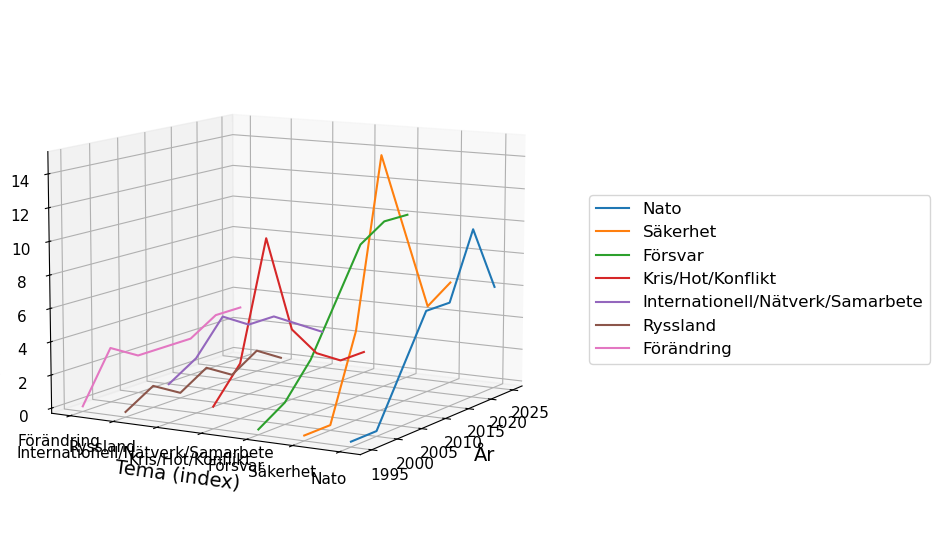

In [64]:
#azimut
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

years = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])
themes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt', 'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']

Z = np.array([
    [0, 0, 3, 6, 6, 10, 6],    # Nato
    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet
    [0, 1, 3, 6, 9, 10, 10],  # Försvar
    [1, 3, 10, 4, 2, 1, 1],    # Kris/Hot/Konflikt
    [2, 3, 5, 4, 4, 3, 2],      # Internationell...
    [0, 1, 0, 1, 0, 1, 0],      # Ryssland
    [0, 3, 2, 2, 2, 3, 3]      # Förändring
])

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

for i, theme in enumerate(themes):
    ax.plot(years, [i]*len(years), Z[i], label=theme)

ax.set_xlabel('År')
ax.set_ylabel('Tema (index)')
ax.set_zlabel('Tematisk intensitet')
ax.set_yticks(range(len(themes)))
ax.set_yticklabels(themes)

# Flyttar legenden till höger om grafen
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

# Kameravinkel
#ax.view_init(elev=20, azim=-60)
ax.view_init(elev=10, azim=-150)


plt.show()

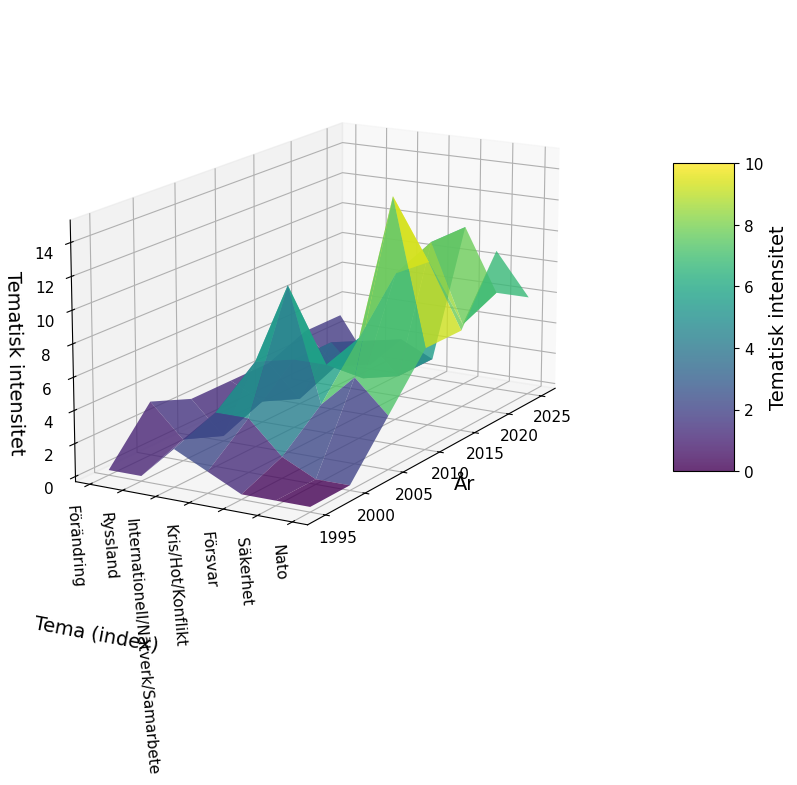

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Data för plotten
years = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])
themes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt', 'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']

Z = np.array([
    [0, 0, 3, 6, 6, 10, 6],     # Nato
    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet
    [0, 1, 3, 6, 9, 10, 10],  # Försvar
    [1, 3, 10, 4, 2, 1, 1],     # Kris/Hot/Konflikt
    [2, 3, 5, 4, 4, 3, 2],       # Internationell...
    [0, 1, 0, 1, 0, 1, 0],       # Ryssland
    [0, 3, 2, 2, 2, 3, 3]        # Förändring
])

# Skapa figuren och 3D-axlarna
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Skapa meshgrid för X och Y för att matcha Z-dimensionerna
X_mesh, Y_mesh = np.meshgrid(years, np.arange(len(themes)))

# Rita ytan
surf = ax.plot_surface(X_mesh, Y_mesh, Z, cmap='viridis', edgecolor='none', alpha=0.8)

# Sätt axel-etiketter
ax.set_xlabel('År')
# Använd 'labelpad' för att flytta Y-axelns huvudetikett "Tema (index)" bort från temanamnen
ax.set_ylabel('Tema (index)', labelpad=50) # Justera 'labelpad' för önskat avstånd
ax.set_zlabel('Tematisk intensitet')

# Sätt Y-axelns "ticks" och etiketter till temanamnen
ax.set_yticks(np.arange(len(themes)))
yticklabels = ax.set_yticklabels(themes) 

# Rotera varje Y-axel-etikett (temanamn) för bättre läsbarhet i 3D
for label in yticklabels:
    label.set_rotation(-85) # Justera vinkeln (t.ex. -15, 0, 30, 45, 60, 90)

# Justera axlarnas proportioner för att sträcka ut dem
ax.set_box_aspect((2, 1, 1)) # (x_ratio, y_ratio, z_ratio)

# Justera kameravinkeln för 3D-vyn
ax.view_init(elev=15, azim=-150)

# Lägg till en färgbar för att förklara Z-värdena
fig.colorbar(surf, shrink=0.5, aspect=5, label='Tematisk intensitet')

# Visa plotten
plt.show()

In [66]:
"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data
years = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])
themes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt',
          'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']

# Tematisk intensitet: 7 teman × 7 år
Z = np.array([
    [0, 0, 3, 6, 6, 10, 6],   # Nato
    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet
    [0, 1, 3, 6, 9, 10, 10],  # Försvar
    [1, 3, 10, 4, 2, 1, 1],   # Kris/Hot/Konflikt
    [2, 3, 5, 4, 4, 3, 2],    # Internationell...
    [0, 1, 0, 1, 0, 1, 0],    # Ryssland
    [0, 3, 2, 2, 2, 3, 3]     # Förändring
])

# För att skapa scatter-koordinater:
X, Y, Z_flat = [], [], []
labels = []

for i, theme in enumerate(themes):
    for j, year in enumerate(years):
        X.append(year)
        Y.append(i)
        Z_flat.append(Z[i][j])
        labels.append(theme)

# Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X, Y, Z_flat, c=Z_flat, cmap='plasma', s=60, edgecolor='k', alpha=0.8)

# Axlar och etiketter
ax.set_xlabel('År')
ax.set_ylabel('Tema')
ax.set_zlabel('Tematisk intensitet')
ax.set_yticks(np.arange(len(themes)))
ax.set_yticklabels(themes, rotation=330, ha='right')

# Färgskala
fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=10)

plt.title('3D scatter: Tematisk utveckling 1995–2025')
plt.tight_layout()
plt.show()

"""

"\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom mpl_toolkits.mplot3d import Axes3D\n\n# Data\nyears = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])\nthemes = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt',\n          'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']\n\n# Tematisk intensitet: 7 teman × 7 år\nZ = np.array([\n    [0, 0, 3, 6, 6, 10, 6],   # Nato\n    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet\n    [0, 1, 3, 6, 9, 10, 10],  # Försvar\n    [1, 3, 10, 4, 2, 1, 1],   # Kris/Hot/Konflikt\n    [2, 3, 5, 4, 4, 3, 2],    # Internationell...\n    [0, 1, 0, 1, 0, 1, 0],    # Ryssland\n    [0, 3, 2, 2, 2, 3, 3]     # Förändring\n])\n\n# För att skapa scatter-koordinater:\nX, Y, Z_flat = [], [], []\nlabels = []\n\nfor i, theme in enumerate(themes):\n    for j, year in enumerate(years):\n        X.append(year)\n        Y.append(i)\n        Z_flat.append(Z[i][j])\n        labels.append(theme)\n\n# Plot\nfig = plt.figure(figsize=(10, 6))\nax = fig.add_subp

/tmp/ipykernel_667/3206702262.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


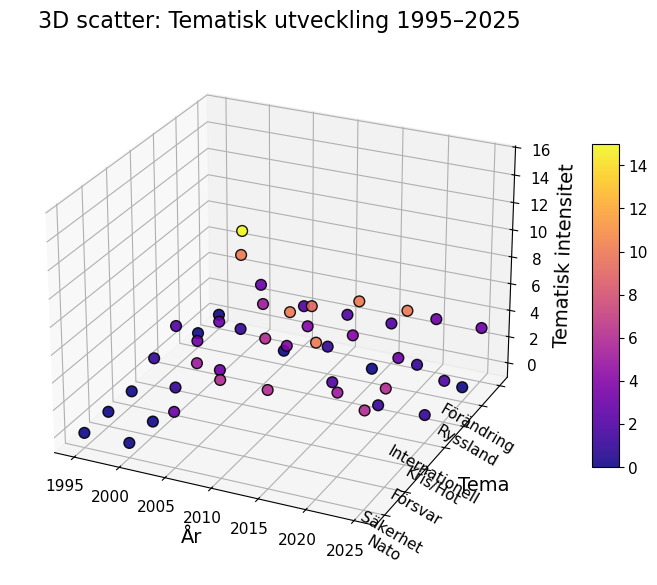

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Data
years = np.array([1995, 2000, 2005, 2010, 2015, 2020, 2025])
themes_full = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot/Konflikt',
               'Internationell/Nätverk/Samarbete', 'Ryssland', 'Förändring']

# Alternativt: kortare temanamn
themes_short = ['Nato', 'Säkerhet', 'Försvar', 'Kris/Hot',
                'Internationell', 'Ryssland', 'Förändring']

# Intensitetsdata (7×7)
Z = np.array([
    [0, 0, 3, 6, 6, 10, 6],   # Nato
    [0, 0, 5, 15, 10, 5, 6],  # Säkerhet
    [0, 1, 3, 6, 9, 10, 10],  # Försvar
    [1, 3, 10, 4, 2, 1, 1],   # Kris/Hot
    [2, 3, 5, 4, 4, 3, 2],    # Internationell...
    [0, 1, 0, 1, 0, 1, 0],    # Ryssland
    [0, 3, 2, 2, 2, 3, 3]     # Förändring
])

# Skapa koordinater
X, Y, Z_flat = [], [], []

for i in range(len(themes_short)):
    for j, year in enumerate(years):
        X.append(year)
        Y.append(i)
        Z_flat.append(Z[i][j])

# Plot
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X, Y, Z_flat, c=Z_flat, cmap='plasma', s=60, edgecolor='k', alpha=0.9)

# Etiketter och rotation
ax.set_xlabel('År')
ax.set_ylabel('Tema')
ax.set_zlabel('Tematisk intensitet')
ax.set_yticks(np.arange(len(themes_short)))
ax.set_yticklabels(themes_short, rotation=330, ha='right')

# Kameravinkel för bättre läsbarhet
ax.view_init(elev=25, azim=-65)

# Färgskala
fig.colorbar(scatter, ax=ax, shrink=0.6, aspect=12)

plt.title('3D scatter: Tematisk utveckling 1995–2025')
plt.tight_layout()
plt.show()
